In [16]:
# Install required library

!pip install librosa
!pip install memory-profiler
!pip install sounddevice
!pip install wavio
!pip install tensorflow-estimator==1.15

     -------------------------------------- 503.4/503.4 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires tensorboard<1.16.0,>=1.15.0, but you have tensorboard 2.4.0 which is incompatible.
tensorflow 1.15.0 requires tensorflow-estimator==1.15.1, but you have tensorflow-estimator 1.15.0 which is incompatible.


# Import Library

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

import glob
from memory_profiler import memory_usage
import gc

# Dataset Preparation (Spectrogram Creation)

In [2]:
# mel-spectrogram

def create_spectrogram(filepath,save_path):
  plt.interactive(False)
  clip,sample_rate=librosa.load(filepath,sr=None)
  fig=plt.figure(figsize=[0.72,0.72])
  ax=fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  S=librosa.feature.melspectrogram(y=clip,sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
  fig.savefig(save_path,dpi=400,bbox_inches='tight',pad_inches=0)
  plt.close()
  fig.clf()
  plt.close(fig)
  plt.close('all')
  del filepath,save_path,clip,sample_rate,fig,ax,S

In [5]:
# Finding all train files (sound wave file)

train_list=[]
path = './dataset/raw/train/'    # Change path here
files = []

for r, d, f in os.walk(path):
    for file in f:
        if '.m4a' in file:    # Change file extension here
            files.append(os.path.join(r, file))

for f in files:
    train_list.append(f)

    
#Finding all test files (sound wave file)

test_list=[]
path = './dataset/raw/test/'    # Change path here
files = []

for r, d, f in os.walk(path):
    for file in f:
        if '.m4a' in file:    # Change file extension here
            files.append(os.path.join(r, file))

for f in files:
    test_list.append(f)

In [6]:
# Checking train and test files

print("Train: ", len(train_list))
print("Test: ", len(test_list))

Train:  0
Test:  0


In [ ]:
%load_ext memory_profiler
%memit   #Emit memory

In [ ]:
#Creating spectrograms and storing to their respective directory (Train)

for filepath in train_list:
  #filename=filepath.split('/')[-1].split('.')[0]   # Linux
  filename=filepath.split('\\')[-1].split('.')[0]   # Windows
  create_spectrogram(filepath,'./dataset/spectrogram/train_images/'+filename+'.jpg')

gc.collect()

In [ ]:
#Creating spectrograms and storing to their respective directory (Train)

for filepath in train_list:
  #filename=filepath.split('/')[-1].split('.')[0]   # Linux
  filename=filepath.split('\\')[-1].split('.')[0]   # Windows
  create_spectrogram(filepath,'./dataset/spectrogram/test_images/'+filename+'.jpg')

gc.collect()

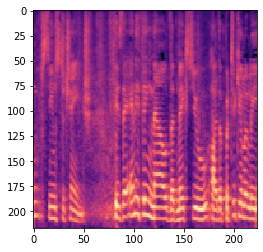

In [8]:
# Checking random images

%matplotlib inline
#img_test=cv2.imread('./voxceleb/vox2_abc/train_images/id04676-5BiS5pBQ5c4-00018.jpg')
img_test=cv2.imread('./dataset/spectrogram/train_images/id00029-96Z18I2UKAE-00001.jpg')
img_test=cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

In [4]:
#Getting training images_list

X_train = []
temp_file_list_= os.listdir('./dataset/spectrogram/train_images/')    # Change path here
for filename in temp_file_list_:
  X_train.append(str('./dataset/spectrogram/train_images/'+filename))    # Change path here

#Getting test images_list.

X_test = []
temp_file_list_= os.listdir('./dataset/spectrogram/test_images/')    # Change path here
for filename in temp_file_list_:
  X_test.append(str('./dataset/spectrogram/test_images/'+filename))    # Change path here

# Checking train and test files

print("Train: ", len(X_train))
print("Test: ", len(X_test))

Train:  392631
Test:  99376


# Building batch generator (Pairing)

In [5]:
import cv2

def load_img(path):
  img=cv2.imread(path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224, 224))    # Resize to (224,224)
  return img

def generate_idxs(X):
    idxs1=np.random.randint(0,len(X),1)[0]
    return idxs1

def same_label_index(X):

  while True:
    idx1=generate_idxs(X)
    idx2=generate_idxs(X)
    file1_dir=X[idx1]
    file2_dir=X[idx2]
    lb1=file1_dir.split("/")[-1].split("-")[0]
    lb2=file2_dir.split("/")[-1].split("-")[0]
    if lb1==lb2:
      break

  return idx1,idx2

def different_label_index(X):
  while True:
    idx1=generate_idxs(X)
    idx2=generate_idxs(X)
    file1_dir=X[idx1]
    file2_dir=X[idx2]
    lb1=file1_dir.split("/")[-1].split("-")[0]
    lb2=file2_dir.split("/")[-1].split("-")[0]
    if lb1!=lb2:
      break

  return idx1,idx2

def batch_generator(X,batch_size):
  while True:
    data=[np.zeros((batch_size,224, 224, 3)) for i in range(2)]
    tar=[np.zeros(batch_size,)]

    #Generating same pairs
    
    for i in range(0,batch_size//2):
      idx1,idx2=same_label_index(X)
      img1=load_img(X[idx1])
      img1=img1/255
      img2=load_img(X[idx2])
      img2=img2/255

      data[0][i,:,:,:]=img1
      data[1][i,:,:,:]=img2
      tar[0][i]=1

    #Generating different pairs
    
    for k in range(batch_size//2,batch_size):
      idx1,idx2=different_label_index(X)
      img1=load_img(X[idx1])
      img1=img1/255
      img2=load_img(X[idx2])
      img2=img2/255

      data[0][k,:,:,:]=img1
      data[1][k,:,:,:]=img2
      tar[0][k]=0
    np.delete(data[0],np.where(~data[0].any(axis=1))[0], axis=0)
    np.delete(data[1],np.where(~data[1].any(axis=1))[0], axis=0)
    yield data,tar

In [6]:
# Calculating suitable steps per epoch

import math

## Change the parameter here
BATCH_SIZE = 64
TRAINING_SIZE = 392631 
VALIDATION_SIZE = 99376

# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)

print("steps_per_epoch: ", steps_per_epoch)

steps_per_epoch:  6135


# Building network structure

## MobileNetV2

In [7]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda,Input,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

# Build contrastive loss
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def get_encoder(input_size): 
  model = MobileNetV2(input_shape=input_size,include_top=False,weights=None,classes=1,pooling="avg")  
  return model

def get_siamese_network(encoder,input_size):
  input1=Input(input_size)
  input2=Input(input_size)

  encoder_l=encoder(input1)
  encoder_r=encoder(input2)
  
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoder_l, encoder_r])
  output = Flatten()(L1_distance)
  output = Dense(1,activation='sigmoid')(output)
  siam_model=Model(inputs=[input1,input2],outputs=output)
  return siam_model

opt=Adam(lr=3e-4)
encoder=get_encoder((224,224,3))
siamese_net=get_siamese_network(encoder,(224,224,3))
siamese_net.compile(loss=loss(margin=1),optimizer=opt,metrics=["acc"])
siamese_net.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 1280)         2257984     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambd

## SqueezeNet

In [4]:
# Install SqueezeNet library

!pip install keras_squeezenet

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 503.4/503.4 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 1.5 MB/s eta 0:00:00
  Created wheel for keras_squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=3591 sha256=81146ee6719d67597465f991ddfd0722a322ba48fb6d3999ce2af763f88b2496
  Stored in directory: c:\users\owner\appdata\local\pip\cache\wheels\3f\8d\f6\8ab612d1c02d4f3da2660139414474ef1359fd72fb61814050
Successfully built keras_squeezenet
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.0
    Uninstalling tensorflow-estimator-1.15.0:
      Successfully uninstalled tensorflow-estimator-1.15.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0


In [8]:
'''
If there is an error,

go to <path>/keras_squeezenet/squeezenet.py

change 
from keras.applications.imagenet_utils import _obtain_input_shape
to
from keras_applications.imagenet_utils import _obtain_input_shape

and

change
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
to
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
'''

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Lambda,Input,Dense,Flatten
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.applications import MobileNetV2
from keras.optimizers import Adam, SGD
from keras_squeezenet import SqueezeNet

# Build contrastive loss
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def get_encoder(input_size):
  model = SqueezeNet(input_shape=input_size,include_top=False,weights=None,classes=1,pooling="avg")
  return model

def get_siamese_network(encoder,input_size):
  input1=Input(input_size)
  input2=Input(input_size)

  encoder_l=encoder(input1)
  encoder_r=encoder(input2)
  
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoder_l, encoder_r])

  output=Dense(1,activation='sigmoid')(L1_distance)
  siam_model=Model(inputs=[input1,input2],outputs=output)
  return siam_model

opt=Adam(lr=3e-4)
encoder=get_encoder((224,224,3))
siamese_net=get_siamese_network(encoder,(224,224,3))
siamese_net.compile(loss=loss(margin=1),optimizer=opt,metrics=["acc"])
siamese_net.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
squeezenet (Model)              (None, 512)          722496      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           squeezenet[1][0]           

## MCUNet

In [ ]:
# Install required library

!pip install torchvision 
!pip install prettytable
!pip uninstall pytorch2keras

In [13]:
'''
If there is an error,

go to <path>/onnx2keras/operation_layers.py

modify convert_clip() method by adding the following lines at the beginning of the convert_clip() method

def convert_clip(node, params, layers, lambda_func, node_name, keras_name):
    if len(node.input) == 3:
        params["min"] = ensure_numpy_type(layers[node.input[1]]).astype(int)
        params["max"] = ensure_numpy_type(layers[node.input[2]]).astype(int)
    else:
        # you can raise Exception here to make sure the above assignments are happening always.
        pass
'''

import torch.nn as nn
import torch

from tinynas.nn.networks import ProxylessNASNets
import json
with open("./assets/configs/mcunet-256kb-1mb_imagenet.json") as f:
    config = json.load(f)
base_model = ProxylessNASNets.build_from_config(config)
#base_model.classifier = nn.Sequential(*(list(base_model.classifier.children())[:-1]))

'''
import torch.nn as nn
import torch

target_platform = "proxyless_mobile"
# proxyless_gpu, proxyless_mobile, proxyless_mobile14 are also avaliable.
base_model = torch.hub.load('mit-han-lab/ProxylessNAS', target_platform, pretrained=True)
#base_model.classifier = nn.Sequential(*(list(base_model.classifier.children())[:-1]))
base_model.classifier = nn.Identity()
base_model.eval()
'''

checkpoint = torch.load('./assets/pt_ckpt/mcunet-256kb-1mb_imagenet.pth')
try:
    checkpoint.eval()
except AttributeError as error:
    print ("error")

base_model.load_state_dict(checkpoint['state_dict'])
### now you can evaluate it
base_model.eval()

error


ProxylessNASNets(
  (first_conv): ConvLayer(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU6(inplace=True)
  )
  (blocks): ModuleList(
    (0): MobileInvertedResidualBlock(
      (mobile_inverted_conv): MBInvertedConvLayer(
        (depth_conv): Sequential(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU6(inplace=True)
        )
        (point_linear): Sequential(
          (conv): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): MobileInvertedResidualBlock(
      (mobile_inverted_conv): MBInvertedConvLayer(
        (inverted_bot

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print("Total Trainable Params: {:,}".format(total_params))
    #return total_params
    
count_parameters(base_model)

+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                     first_conv.conv.weight                     |    432     |
|                      first_conv.bn.weight                      |     16     |
|                       first_conv.bn.bias                       |     16     |
|      blocks.0.mobile_inverted_conv.depth_conv.conv.weight      |    144     |
|       blocks.0.mobile_inverted_conv.depth_conv.bn.weight       |     16     |
|        blocks.0.mobile_inverted_conv.depth_conv.bn.bias        |     16     |
|     blocks.0.mobile_inverted_conv.point_linear.conv.weight     |    128     |
|      blocks.0.mobile_inverted_conv.point_linear.bn.weight      |     8      |
|       blocks.0.mobile_inverted_conv.point_linear.bn.bias       |     8      |
| blocks.1.mobile_inverted_conv.inverted

In [15]:
# Convert network structure from PyTorch to TensorFlow format

from pytorch2keras.converter import pytorch_to_keras
from torch.autograd import Variable
import torch
import torch.nn as nn
import numpy as np

input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))

from pytorch2keras import pytorch_to_keras

# we should specify shape of the input tensor
k_model = pytorch_to_keras(base_model, input_var, [(3, 224, 224, )], change_ordering=True, verbose=True, name_policy="renumerate",)  
#k_model = pytorch_to_keras(base_model, input_var, [(3, None, None,)], verbose=True)  

k_model.summary()

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight classifier.linear.weight with shape (1000, 160).
DEBUG:onnx2keras:Found weight classifier.linear.bias with shape (1000,).
DEBUG:onnx2keras:Found weight onnx::Conv_558 with shape (16, 3, 3, 3).
DEBUG:onnx2keras:Found weight onnx::Conv_559 with shape (16,).
DEBUG:onnx2keras:Found weight onnx::Conv_561 with shape (16, 1, 3, 3).
DEBUG:onnx2keras:Found weight onnx::Conv_562 with shape (16,).
DEBUG:onnx2keras:Found weight onnx::Conv_564 with shape (8, 16, 1, 1).
DEBUG:onnx2keras:Found weight onnx::Conv_565

DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: input.4
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [3, 3], 'pads': [1, 1, 1, 1], 'strides': [2, 2], 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input_0).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_558).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_559).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Conv_343).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_570).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_571).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_346
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': Tru

DEBUG:onnx2keras:Check input 1 (name onnx::Conv_582).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_583).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Add
DEBUG:onnx2keras:node_name: input.68
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Add_581).
DEBUG:onnx2keras:Check input 1 (name input.44).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:add:Convert inputs to Keras/TF layers if needed.
DEBUG:onnx2ke

DEBUG:onnx2keras:node_name: onnx::Clip_379
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_380
DEBUG:onnx2keras:node_params: {'value': array(6., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Clip
DEBUG:onnx2keras:node_name: onnx::Conv_381
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onn

DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_397
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_398
DEBUG:onnx2keras:node_params: {'value': array(6., dtype=float32), 'change_ordering': True, 'name_policy': 'renum

DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Add
DEBUG:onnx2keras:node_name: input.164
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Add_617).
DEBUG:onnx2keras:Check input 1 (name input.140).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:add:Convert inputs to Keras/TF layers if needed.
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: input.172
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are availab

DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_431
DEBUG:onnx2keras:node_params: {'value': array(6., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Clip
DEBUG:onnx2keras:node_name: onnx::Conv_432
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input.196).
DEBUG:onnx2keras:Check input 1 (name onnx::Clip_430).
DEBUG:onnx2keras:Check input 2 (name onnx::Clip_431).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:clip:Using ReLU(6) instead of clip
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:on

DEBUG:onnx2keras:node_params: {'value': array(6., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Clip
DEBUG:onnx2keras:node_name: onnx::Conv_449
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input.228).
DEBUG:onnx2keras:Check input 1 (name onnx::Clip_447).
DEBUG:onnx2keras:Check input 2 (name onnx::Clip_448).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:clip:Using ReLU(6) instead of clip
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: onnx::Add_644
DEBUG:onnx2keras:node_params: {'dilations

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input.260).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_657).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_658).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_467
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2k

DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: input.300
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 192, 'kernel_shape': [3, 3], 'pads': [1, 1, 1, 1], 'strides': [1, 1], 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Conv_482).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_669).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_670).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution


DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input.324).
DEBUG:onnx2keras:Check input 1 (name onnx::Clip_498).
DEBUG:onnx2keras:Check input 2 (name onnx::Clip_499).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:clip:Using ReLU(6) instead of clip
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: input.332
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Conv_500).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_681).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name

DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_518
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_519
DEBUG:onnx2keras:node_params: {'value': array(6., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:######
DEBUG:o

DEBUG:onnx2keras:Check input 1 (name onnx::Conv_705).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_706).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:conv:Number of groups is equal to input channels, use DepthWise convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Constant
DEBUG:onnx2keras:node_name: onnx::Clip_536
DEBUG:onnx2keras:node_params: {'value': array(0., dtype=float32), 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:... f

DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: onnx::ReduceMean_716
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [1, 1], 'pads': [0, 0, 0, 0], 'strides': [1, 1], 'change_ordering': True, 'name_policy': 'renumerate'}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name onnx::Conv_551).
DEBUG:onnx2keras:Check input 1 (name onnx::Conv_717).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:Check input 2 (name onnx::Conv_718).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX op

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
LAYER_0_pad (ZeroPadding2D)     (None, 226, 226, 3)  0           input_0[0][0]                    
__________________________________________________________________________________________________
LAYER_0 (Conv2D)                (None, 112, 112, 16) 448         LAYER_0_pad[0][0]                
__________________________________________________________________________________________________
LAYER_3 (ReLU)                  (None, 112, 112, 16) 0           LAYER_0[0][0]                    
____________________________________________________________________________________________

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Get input
new_input = k_model.input

# Find the layer to connect
new_output = k_model.layers[-2].output

# Build a new model
convertedModel = Model(new_input, new_output)
convertedModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
LAYER_0_pad (ZeroPadding2D)     (None, 226, 226, 3)  0           input_0[0][0]                    
__________________________________________________________________________________________________
LAYER_0 (Conv2D)                (None, 112, 112, 16) 448         LAYER_0_pad[0][0]                
__________________________________________________________________________________________________
LAYER_3 (ReLU)                  (None, 112, 112, 16) 0           LAYER_0[0][0]                    
____________________________________________________________________________________________

In [18]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Activation,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss

left_input  = Input((224, 224,3))
right_input = Input((224, 224,3))

base_network = convertedModel

processed_a = base_network(left_input)
processed_b = base_network(right_input)

L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
L1_distance = L1_layer([processed_a , processed_b])
output = Flatten()(L1_distance)
prediction = Dense(1,activation='sigmoid')(output)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
opt=Adam(lr=3e-4)
siamese_net.compile(loss=loss(margin=1),optimizer=opt,metrics=["acc"])
#siamese_net.compile(loss='binary_crossentropy',optimizer=opt,metrics=["acc"])
siamese_net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 160)          560648      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 160)          0           model_2[3][0]              

# Training

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)    # Apply early stopping (optional)
mc = ModelCheckpoint('./saved_model/MCUNetFull_64bs_ContraLoss.hdf5', monitor='acc', verbose=1, save_best_only=True, mode='max')
history=siamese_net.fit_generator(batch_generator(X_train,64),steps_per_epoch=1000,epochs=15,validation_data=batch_generator(X_test,64),validation_steps=50,callbacks=[mc],shuffle=True)

# Result

In [ ]:
# Loss graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Acc graph

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Data Inspection

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model

#Same pair test.
idx1,idx2=same_label_index(X_test)
X1=[np.zeros((1,224,224,3)) for i in range(2)]

img1=load_img(X_test[idx1])
img1=np.array(img1)
img1=img1/255
img2=load_img(X_test[idx2])
img2=np.array(img2)
img2=img2/255

X1[0][0,:,:,:]=img1
X1[1][0,:,:,:]=img2

#Different pair.
idx1,idx2=different_label_index(X_test)
X2=[np.zeros((1,224,224,3)) for i in range(2)]

img1=load_img(X_test[idx1])
img1=np.array(img1)
img1=img1/255
img2=load_img(X_test[idx2])
img2=np.array(img2)
img2=img2/255


X2[0][0,:,:,:]=img1
X2[1][0,:,:,:]=img2

model=load_model('./saved_model/MCUNetFull_64bs_ContraLoss.hdf5')
print(model.predict(X1))
print(model.predict(X2))

In [ ]:
# Test dataset preparation for making a prediction

def create_spectrogram(filepath,save_path):
  plt.interactive(False)
  clip,sample_rate=librosa.load(filepath,sr=None)
  fig=plt.figure(figsize=[0.72,0.72])
  ax=fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  S=librosa.feature.melspectrogram(y=clip,sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
  fig.savefig(save_path,dpi=400,bbox_inches='tight',pad_inches=0)
  plt.close()
  fig.clf()
  plt.close(fig)
  plt.close('all')
  del filepath,save_path,clip,sample_rate,fig,ax,S

def load_img(path):
  img=cv2.imread(path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  return img

#This loop takes each file and converts them into spectrogram and save them as jpeg image.
files_list=['test1.wav','test2.wav','test3.wav','JJ_00000.wav','JJ_00001.wav','Vik.wav','Sudhanshu.wav','Vik3.wav']
for i in range(len(files_list)):
    filepath='Test_audio_files/'+files_list[i]
    new_name=files_list[i].split('.')[0]
    savepath='Generated_images/'+new_name+'.jpg'
    create_spectrogram(filepath,savepath)

In [ ]:
#This part contains the list of all file names and a function which compares them with the supplied input.
all_files_list=['test1.jpg','test2.jpg','test3.jpg','JJ_00000.jpg','JJ_00001.jpg','Vik.jpg','Sudhanshu.jpg','Vik3.jpg']

def match_file(filename):
    score_list=[]
    img1=load_img('Generated_images/'+filename)
    img1=img1/255
    for i in range(len(all_files_list)):
        
        img2=load_img('Generated_images/'+all_files_list[i])
        img2=img2/255
        X=[np.zeros((1,224,224,3)) for i in range(2)]
        Y=[np.zeros(1,)]
        X[0][0,:,:,:]=img1
        X[1][0,:,:,:]=img2
        score_list.append(model.predict(X))
    score_list=np.array(score_list)
    idx=np.argmax(score_list)
    return all_files_list[idx],score_list

In [ ]:
# Prediction result

name,score=match_file('./Generated_images/JJ_00000.jpg')

print(score)
print(name)

# Real-Time Detection

In [1]:
import librosa
import cv2
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import time
import IPython.display
import sklearn

model=load_model('./saved_model/MCUNetFull_64bs_ContraLoss.hdf5',compile=False)

def create_spectrogram(filepath,save_path):
  plt.interactive(False)
  clip,sample_rate=librosa.load(filepath,sr=None)
  fig=plt.figure(figsize=[0.72,0.72])
  ax=fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  S=librosa.feature.melspectrogram(y=clip,sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
  fig.savefig(save_path,dpi=400,bbox_inches='tight',pad_inches=0)
  plt.close()
  fig.clf()
  plt.close(fig)
  plt.close('all')
  del filepath,save_path,clip,sample_rate,fig,ax,S

def load_img(path):
  img=cv2.imread(path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  return img

def match_file(filename):
    score_list=[]
    img1=load_img(filename)
    img1=img1/255
    for i in range(len(all_files_list)):
        img2=load_img('./inference/data/img/'+all_files_list[i])    # Change reference dataset here
        img2=img2/255
        X=[np.zeros((1,224,224,3)) for i in range(2)]
        Y=[np.zeros(1,)]
        X[0][0,:,:,:]=img1
        X[1][0,:,:,:]=img2
        score_list.append(model.predict(X))
    score_list=np.array(score_list)
    idx=np.argmax(score_list)
    return all_files_list[idx], score_list[idx], score_list

all_files_list=[]

for file in os.listdir("./inference/data/img/"):    # Change reference dataset here
    all_files_list.append(file)

# Sampling frequency
freq = 22050

while(1):
    print("Recording...")
    duration = 3
    recording = sd.rec(int(duration * freq),samplerate=freq, channels=2)
    sd.wait()
    print("Done...")
    wavInspectPath = "./inference/inspectVoice.wav"    # Change target dataset here
    imgInspectPath = "./inference/inspectVoice.jpg"
    write(wavInspectPath, freq, recording)

    x, fs = librosa.load(wavInspectPath)
    fig=plt.figure(figsize=[0.72,0.72])
    ax=fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    create_spectrogram(wavInspectPath, imgInspectPath)
    start = time.time()
    name,score,score_list=match_file(imgInspectPath)
    end = time.time()
        
    name = (name.split(".")[0]).split("_")[0]
    if(float(score)*100 >= 80):
        print("Authorized user: ", name)
    print("Accuracy: {:.2f}%".format(float(score)*100))
    print("Inference Time: {:.4f}s".format(end - start))
        